# Task 2 - EDA

Task 2 - EDA

Using this dataset, you are supposed to prepare an Exploratory Data Analysis (EDA) report
in PDF format that shows at least 3 different insights about this data (number of examples
per class, top frequent n-grams generally and per class, lengths of examples in words and
letters, ….) . Feel free to show your insights in a good format (description, tables, charts,
…).
Note that you can prepare the PDF manually after generating the analytics in any other
format (CSV, xls, doc), …).
Note: Use stories data only (not comments).

Environment Setup

Enable the GPU

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Dependencies Installation

In [ ]:
!pip install gdown
!pip install pyarabic
!pip install farasapy
!pip install emoji
!pip install transformers
!git clone https://github.com/aub-mind/arabert.git

In [197]:
from google.colab import files
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# for styling
plt.style.use('seaborn-whitegrid')

# natural language processing: n-gram ranking
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
# add appropriate words that will be ignored in the analysis
ADDITIONAL_STOPWORDS = ['covfefe']

from arabert.preprocess import ArabertPreprocessor
from nltk.util import ngrams
from farasa.segmenter import FarasaSegmenter

# Initialize the ArabertPreprocessor
arabert_processor = ArabertPreprocessor(model_name="aubmindlab/bert-base-arabertv02")

from collections import Counter

from sklearn.preprocessing import LabelEncoder

<ipython-input-197-2f96fb646871>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


The Cleaning Function

In [ ]:
import re
import string,emoji, re
import pyarabic.araby as ar
import functools, operator
import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def data_cleaning (text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub("(\s\d+)","",text)
    text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
    text = re.sub("\d+", " ", text)
    text = ar.strip_tashkeel(text)
    text = ar.strip_tatweel(text)
    text = text.replace("#", " ");
    text = text.replace("@", " ");
    text = text.replace("_", " ");

    # Remove arabic signs
    text = text[0:2] + ''.join([text[i] for i in range(2, len(text)) if text[i]!=text[i-1] or text[i]!=text[i-2]])
    text =  re.sub(r'([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', '', text)
    text =  '' if text in arabic_stop_words else text
    from nltk.stem.isri import ISRIStemmer
    text=ISRIStemmer().stem(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    em = text
    em_split_emoji = get_emoji_regexp().split(em)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = " ".join(em_split)
    text = re.sub(r'(.)\1+', r'\1', text)

    text = text.replace("آ", "ا")
    text = text.replace("إ", "ا")
    text = text.replace("أ", "ا")
    text = text.replace("ؤ", "و")
    text = text.replace("ئ", "ي")
    return text

## EDA and Visualization

We will show:

1- Number of examples per class.

2- Top frequent n-grams generally and per class.

3- Lengths of examples in words and letters.

### Load The Data

In [50]:
uploaded = files.upload()

Saving stories_art-et-culture.csv to stories_art-et-culture (2).csv
Saving stories_economie.csv to stories_economie (1).csv
Saving stories_faits-divers.csv to stories_faits-divers (1).csv
Saving stories_marocains-du-monde.csv to stories_marocains-du-monde (1).csv
Saving stories_medias.csv to stories_medias (1).csv
Saving stories_orbites.csv to stories_orbites (1).csv
Saving stories_politique.csv to stories_politique (1).csv
Saving stories_regions.csv to stories_regions (1).csv
Saving stories_societe.csv to stories_societe (1).csv
Saving stories_sport.csv to stories_sport (1).csv
Saving stories_tamazight.csv to stories_tamazight (1).csv


In [93]:
def number_of_examples_per_class(df):
  print("The number of examples per the art-et-culture class is {}".format(df.shape[0]))


def top_frequent_n_grams(df):
  # Your list of strings
  story_list = list(df['story'])

  # Combine the list of strings into a single large string
  separator = " "
  combined_string = separator.join(story_list)

  # Your Arabic text
  arabic_text = combined_string

  # Preprocess and tokenize the text
  preprocessed_arabic_text = arabert_processor.preprocess(arabic_text)
  arabic_tokens = preprocessed_arabic_text.split()

  # Example: Extract bi-grams and tri-grams
  bi_grams = extract_ngrams(arabic_tokens, 2)
  tri_grams = extract_ngrams(arabic_tokens, 3)

  # Count occurrences of each bi-gram and tri-gram
  bi_gram_counts = Counter(bi_grams)
  tri_gram_counts = Counter(tri_grams)

  # Print the top 10 bi-grams and their occurrence counts
  print("Top 10 Bi-grams with Occurrence Counts:")
  for bi_gram, count in bi_gram_counts.most_common(10):
      print(f"{bi_gram}: {count}")

  # Print the top 10 tri-grams and their occurrence counts
  print("\nTop 10 Tri-grams with Occurrence Counts:")
  for tri_gram, count in tri_gram_counts.most_common(10):
      print(f"{tri_gram}: {count}")


def lengths_of_examples_in_words_and_letters(df):
  # Your list of strings
  story_list = list(df['story'])

  counter = 0
  for story in story_list:

    counter += 1

    # Your Arabic text
    arabic_text = story

    # Preprocess and tokenize the text
    preprocessed_arabic_text = arabert_processor.preprocess(arabic_text)

    # Calculate the length in words
    word_count = len(preprocessed_arabic_text.split())

    # Calculate the length in letters (including spaces)
    letter_count = len(preprocessed_arabic_text)

    # Print the results
    print("Story {}".format(counter))
    print("Word Count:", word_count)
    print("Letter Count:", letter_count)
    print("_____________________________________")

### **1- stories_art-et-culture.csv**

In [103]:
df_art_et_culture = pd.read_csv('stories_art-et-culture.csv')
df_art_et_culture.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,f06aa998054e11eba66e646e69d991ea,"""بيت الشعر"" يسائل وزير الثقافة عن كوابيس سوداء",الجمعة 02 أكتوبر 2020 - 23:19,هسبريس من الرباط,"وجه ""بيت الشعر في المغرب"" إلى وزير الثقافة وال...",art-et-culture
1,1,f1cf1b9c054e11ebb718646e69d991ea,"مهرجان ""سينما المؤلّف"" يستحضر روح ثريا جبران",الجمعة 02 أكتوبر 2020 - 07:26,هسبريس من الرباط,في ظلّ استمرار حالة الطوارئ الصحية المرتبطة بج...,art-et-culture
2,2,f2d282a4054e11eb800f646e69d991ea,"فيلم ""بدون عنف"" لهشام العسري ..""كعب الحذاء ووا...",الجمعة 02 أكتوبر 2020 - 04:00,عفيفة الحسينات*,تشير مشاهدة فيلم قصير ضمن الثلاثية الأخيرة للم...,art-et-culture
3,3,f3f46cac054e11eba403646e69d991ea,"""تنين ووهان"" .. مريم أيت أحمد توقِّع أولى ""روا...",الجمعة 02 أكتوبر 2020 - 02:00,حاورَها: وائل بورشاشن,"مِن قَلب أيّام ""الحَجْر""، رأتِ النّورَ الفصول ...",art-et-culture
4,4,f50f0476054e11eba31b646e69d991ea,"مسكر يتخلّى عن دعم ""الوزارة"" بسبب ""الجمهور""",الخميس 01 أكتوبر 2020 - 19:40,هسبريس من الرباط,أعلن الفنان المغربيّ سعيد مسكر تخليه عن مبلغ ا...,art-et-culture


Apply the Cleaning Function

In [104]:
df_art_et_culture['story'] = df_art_et_culture['story'].apply(lambda x: data_cleaning(x))
df_art_et_culture.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,f06aa998054e11eba66e646e69d991ea,"""بيت الشعر"" يسائل وزير الثقافة عن كوابيس سوداء",الجمعة 02 أكتوبر 2020 - 23:19,هسبريس من الرباط,وجه بيت الشعر في المغرب الى وزير الثقافة والشب...,art-et-culture
1,1,f1cf1b9c054e11ebb718646e69d991ea,"مهرجان ""سينما المؤلّف"" يستحضر روح ثريا جبران",الجمعة 02 أكتوبر 2020 - 07:26,هسبريس من الرباط,في ظل استمرار حالة الطواري الصحية المرتبطة بجا...,art-et-culture
2,2,f2d282a4054e11eb800f646e69d991ea,"فيلم ""بدون عنف"" لهشام العسري ..""كعب الحذاء ووا...",الجمعة 02 أكتوبر 2020 - 04:00,عفيفة الحسينات*,تشير مشاهدة فيلم قصير ضمن الثلاثية الاخيرة لمخ...,art-et-culture
3,3,f3f46cac054e11eba403646e69d991ea,"""تنين ووهان"" .. مريم أيت أحمد توقِّع أولى ""روا...",الجمعة 02 أكتوبر 2020 - 02:00,حاورَها: وائل بورشاشن,من قلب ايام الحجر رات النور الفصول الاولى من ر...,art-et-culture
4,4,f50f0476054e11eba31b646e69d991ea,"مسكر يتخلّى عن دعم ""الوزارة"" بسبب ""الجمهور""",الخميس 01 أكتوبر 2020 - 19:40,هسبريس من الرباط,اعلن الفنان المغربي سعيد مسكر تخليه عن مبلغ ال...,art-et-culture


**1- Number of examples per class.**

In [105]:
number_of_examples_per_class(df_art_et_culture)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [106]:
top_frequent_n_grams(df_art_et_culture)

Top 3 Bi-grams with Occurrence Counts:
('من', 'خلال'): 514
('الى', 'ان'): 446
('من', 'اجل'): 361
('في', 'هذا'): 327
('مجموعة', 'من'): 289
('العديد', 'من'): 252
('في', 'المغرب'): 225
('وهو', 'ما'): 223
('ان', 'هذا'): 195
('عد', 'من'): 187

Top 3 Tri-grams with Occurrence Counts:
('الثقافة', 'والشباب', 'والرياضة'): 136
('مشيرا', 'الى', 'ان'): 81
('وزارة', 'الثقافة', 'والشباب'): 80
('لجريدة', 'هسبريس', 'الالكترونية'): 66
('المركز', 'السينمايي', 'المغربي'): 65
('الاشارة', 'الى', 'ان'): 61
('تصريح', 'لجريدة', 'هسبريس'): 57
('في', 'تصريح', 'لهسبريس'): 57
('في', 'تصريح', 'لجريدة'): 54
('الدولي', 'لفيلم', 'بمراكش'): 52


**3- Lengths of examples in words and letters**

In [107]:
lengths_of_examples_in_words_and_letters(df_art_et_culture)

Story 1
Word Count: 621
Letter Count: 3670
_____________________________________
Story 2
Word Count: 378
Letter Count: 2331
_____________________________________
Story 3
Word Count: 474
Letter Count: 2666
_____________________________________
Story 4
Word Count: 769
Letter Count: 4623
_____________________________________
Story 5
Word Count: 200
Letter Count: 1151
_____________________________________
Story 6
Word Count: 368
Letter Count: 2181
_____________________________________
Story 7
Word Count: 363
Letter Count: 2257
_____________________________________
Story 8
Word Count: 320
Letter Count: 1842
_____________________________________
Story 9
Word Count: 391
Letter Count: 2200
_____________________________________
Story 10
Word Count: 460
Letter Count: 2670
_____________________________________
Story 11
Word Count: 263
Letter Count: 1590
_____________________________________
Story 12
Word Count: 296
Letter Count: 1788
_____________________________________
Story 13
Word Count: 566


### **2- stories_economie.csv**

In [108]:
df_economie = pd.read_csv('stories_economie.csv')
df_economie.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,2f26392804e911eb98f1646e69d991ea,"أمكراز يعزو ""الفراغ التشريعي"" في قوانين تنظيم ...",الجمعة 02 أكتوبر 2020 - 19:31,هسبريس - محمد الراجي (صور: منير محيمدات),قال محمد أمكراز، وزير الشغل والإدماج المهني، إ...,economie
1,1,312b946804e911eba391646e69d991ea,"""كورونا"" يفاقم تأخر أداء مستحقات مقاولات مغربية",الجمعة 02 أكتوبر 2020 - 13:20,هسبريس - محمد لديب,أثرت أزمة تفشي فيروس كورونا بشكل مباشر على أجا...,economie
2,2,3204e77404e911eb8f5d646e69d991ea,بورصات أوروبية تتراجع بعد إصابة ترامب بكورونا,الجمعة 02 أكتوبر 2020 - 09:02,هسبريس - أ.ف.ب,سجلت البورصات الرئيسية الأوروبية تراجعا لدى بد...,economie
3,3,32b9a18804e911ebb8eb646e69d991ea,ثمانية مُعيقات تقف أمام اندماج المغرب في اقتصا...,الجمعة 02 أكتوبر 2020 - 07:00,هسبريس - يوسف لخضر,قال المجلس الاقتصادي والاجتماعي والبيئي إن اند...,economie
4,4,338683f404e911eba0ed646e69d991ea,تمويل الإرهاب يدفع وزارة العدل إلى تشديد مكافح...,الجمعة 02 أكتوبر 2020 - 06:00,هسبريس - محمد الراجي (صور: منير محيمدات),أجمع المتدخلون في اللقاء التواصلي الذي عقدته و...,economie


Apply the Cleaning Function

In [109]:
df_economie['story'] = df_economie['story'].apply(lambda x: data_cleaning(x))
df_economie.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,2f26392804e911eb98f1646e69d991ea,"أمكراز يعزو ""الفراغ التشريعي"" في قوانين تنظيم ...",الجمعة 02 أكتوبر 2020 - 19:31,هسبريس - محمد الراجي (صور: منير محيمدات),قال محمد امكراز وزير الشغل والادماج المهني ان ...,economie
1,1,312b946804e911eba391646e69d991ea,"""كورونا"" يفاقم تأخر أداء مستحقات مقاولات مغربية",الجمعة 02 أكتوبر 2020 - 13:20,هسبريس - محمد لديب,اثرت ازمة تفشي فيروس كورونا بشكل مباشر على اجا...,economie
2,2,3204e77404e911eb8f5d646e69d991ea,بورصات أوروبية تتراجع بعد إصابة ترامب بكورونا,الجمعة 02 أكتوبر 2020 - 09:02,هسبريس - أ.ف.ب,سجلت البورصات الرييسية الاوروبية تراجعا لدى بد...,economie
3,3,32b9a18804e911ebb8eb646e69d991ea,ثمانية مُعيقات تقف أمام اندماج المغرب في اقتصا...,الجمعة 02 أكتوبر 2020 - 07:00,هسبريس - يوسف لخضر,قال المجلس الاقتصادي والاجتماعي والبييي ان اند...,economie
4,4,338683f404e911eba0ed646e69d991ea,تمويل الإرهاب يدفع وزارة العدل إلى تشديد مكافح...,الجمعة 02 أكتوبر 2020 - 06:00,هسبريس - محمد الراجي (صور: منير محيمدات),اجمع المتدخلون في القاء التواصلي الذي عقدته وز...,economie


**1- Number of examples per class.**

In [110]:
number_of_examples_per_class(df_economie)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [111]:
top_frequent_n_grams(df_economie)

Top 3 Bi-grams with Occurrence Counts:
('في', 'الماية'): 1851
('الى', 'ان'): 623
('مليار', 'درهم'): 516
('من', 'اجل'): 510
('من', 'خلال'): 477
('فيروس', 'كورونا'): 463
('الماية', 'من'): 401
('بنسبة', 'في'): 388
('وهو', 'ما'): 374
('من', 'طرف'): 364

Top 3 Tri-grams with Occurrence Counts:
('في', 'الماية', 'من'): 401
('بنسبة', 'في', 'الماية'): 339
('ب', 'في', 'الماية'): 221
('فيروس', 'كورونا', 'المستجد'): 207
('والمالية', 'واصلاح', 'الادارة'): 176
('الاقتصاد', 'والمالية', 'واصلاح'): 175
('في', 'الماية', 'في'): 163
('و', 'في', 'الماية'): 143
('الى', 'في', 'الماية'): 136
('من', 'السنة', 'الجارية'): 120


**3- Lengths of examples in words and letters**

In [112]:
lengths_of_examples_in_words_and_letters(df_economie)

Story 1
Word Count: 311
Letter Count: 1948
_____________________________________
Story 2
Word Count: 203
Letter Count: 1240
_____________________________________
Story 3
Word Count: 40
Letter Count: 237
_____________________________________
Story 4
Word Count: 350
Letter Count: 2252
_____________________________________
Story 5
Word Count: 558
Letter Count: 3563
_____________________________________
Story 6
Word Count: 237
Letter Count: 1434
_____________________________________
Story 7
Word Count: 307
Letter Count: 1906
_____________________________________
Story 8
Word Count: 366
Letter Count: 2196
_____________________________________
Story 9
Word Count: 225
Letter Count: 1414
_____________________________________
Story 10
Word Count: 155
Letter Count: 981
_____________________________________
Story 11
Word Count: 569
Letter Count: 3764
_____________________________________
Story 12
Word Count: 189
Letter Count: 1186
_____________________________________
Story 13
Word Count: 387
Let

### **3- stories_faits-divers.csv**

In [113]:
df_faits_divers = pd.read_csv('stories_faits-divers.csv')
df_faits_divers.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers


Apply the Cleaning Function

In [114]:
df_faits_divers['story'] = df_faits_divers['story'].apply(lambda x: data_cleaning(x))
df_faits_divers.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قرت الغرفة الجنايية بمحكمة الاستيناف بمدينة ال...,faits-divers
1,1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولايية لشرطة القضايية بمدينة ا...,faits-divers
2,2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,اوقفت عناصر فرقة الشرطة القضايية بالمنطقة الاق...,faits-divers
3,3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر امني مسوول ان التلميذة المتحدرة من جم...,faits-divers
4,4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولايية لشرطة القضايية بم...,faits-divers


**1- Number of examples per class.**

In [115]:
number_of_examples_per_class(df_faits_divers)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [116]:
top_frequent_n_grams(df_faits_divers)

Top 3 Bi-grams with Occurrence Counts:
('النيابة', 'العامة'): 728
('العامة', 'المختصة'): 541
('الحراسة', 'النظرية'): 407
('المشتبه', 'فيه'): 376
('من', 'اجل'): 351
('الدرك', 'الملكي'): 344
('من', 'العمر'): 324
('قبل', 'ان'): 254
('تحت', 'اشراف'): 251
('هذه', 'القضية'): 247

Top 3 Tri-grams with Occurrence Counts:
('النيابة', 'العامة', 'المختصة'): 534
('تدبير', 'الحراسة', 'النظرية'): 239
('اشراف', 'النيابة', 'العامة'): 226
('تحت', 'اشراف', 'النيابة'): 225
('تحت', 'تدبير', 'الحراسة'): 215
('رهن', 'اشارة', 'البحث'): 209
('من', 'العمر', 'سنة'): 200
('الحراسة', 'النظرية', 'رهن'): 193
('النظرية', 'رهن', 'اشارة'): 189
('العامة', 'لامن', 'الوطني'): 186


**3- Lengths of examples in words and letters**

In [117]:
lengths_of_examples_in_words_and_letters(df_faits_divers)

Story 1
Word Count: 202
Letter Count: 1159
_____________________________________
Story 2
Word Count: 158
Letter Count: 972
_____________________________________
Story 3
Word Count: 124
Letter Count: 787
_____________________________________
Story 4
Word Count: 123
Letter Count: 766
_____________________________________
Story 5
Word Count: 109
Letter Count: 660
_____________________________________
Story 6
Word Count: 192
Letter Count: 1194
_____________________________________
Story 7
Word Count: 375
Letter Count: 2094
_____________________________________
Story 8
Word Count: 158
Letter Count: 942
_____________________________________
Story 9
Word Count: 68
Letter Count: 434
_____________________________________
Story 10
Word Count: 168
Letter Count: 1001
_____________________________________
Story 11
Word Count: 332
Letter Count: 1957
_____________________________________
Story 12
Word Count: 162
Letter Count: 934
_____________________________________
Story 13
Word Count: 135
Letter C

### **4- stories_marocains-du-monde.csv**

In [118]:
df_marocains_du_monde = pd.read_csv('stories_marocains-du-monde.csv')
df_marocains_du_monde.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,07b94f7404ee11eb89f9646e69d991ea,عودة مئات المغربيات العالقات في سبتة ومليلية: ...,الخميس 01 أكتوبر 2020 - 14:00,هسبريس من الرباط,بعد أكثر من ستّة أشهر من الإغلاق لحُدودهما الب...,marocains-du-monde
1,1,08f1273404ee11eb907d646e69d991ea,خرموش يدحض افتراءات سفير الجزائر ببلغراد حول ا...,الأربعاء 30 شتنبر 2020 - 05:30,هسبريس من الرباط,"نشرت الجريدة الصربية واسعة الانتشار ""بوليتيكا""...",marocains-du-monde
2,2,09cf02d404ee11eb9069646e69d991ea,"كشف ""الأخبار الزائفة"" يؤهل شابا مغربيا في برنا...",الأربعاء 30 شتنبر 2020 - 01:30,جمال سماحي من تطوان,تأهل الشاب المغربي وائل أبرون، دكتور مهندس في ...,marocains-du-monde
3,3,0ad15bb004ee11ebb18b646e69d991ea,"إسبانيا تمنعُ مغربيات عالقات من ولوج فضاء ""شين...",الثلاثاء 29 شتنبر 2020 - 21:00,هسبريس - عبد السلام الشامخ,لن يكون بمقدورِ المغاربة العالقين في مليلية وس...,marocains-du-monde
4,4,0bad7a1204ee11eb9ae7646e69d991ea,المغرب يشرع غداً في إعادة مئات المواطنين العال...,الثلاثاء 29 شتنبر 2020 - 11:40,هسبريس - عبد الرحيم العسري,يشرع المغرب، غداً الأربعاء، في إعادة مئات المغ...,marocains-du-monde


Apply the Cleaning Function

In [119]:
df_marocains_du_monde['story'] = df_marocains_du_monde['story'].apply(lambda x: data_cleaning(x))
df_marocains_du_monde.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,07b94f7404ee11eb89f9646e69d991ea,عودة مئات المغربيات العالقات في سبتة ومليلية: ...,الخميس 01 أكتوبر 2020 - 14:00,هسبريس من الرباط,بعد اكثر من ستة اشهر من الاغلاق لحدودهما البري...,marocains-du-monde
1,1,08f1273404ee11eb907d646e69d991ea,خرموش يدحض افتراءات سفير الجزائر ببلغراد حول ا...,الأربعاء 30 شتنبر 2020 - 05:30,هسبريس من الرباط,نشرت الجريدة الصربية واسعة الانتشار بوليتيكا م...,marocains-du-monde
2,2,09cf02d404ee11eb9069646e69d991ea,"كشف ""الأخبار الزائفة"" يؤهل شابا مغربيا في برنا...",الأربعاء 30 شتنبر 2020 - 01:30,جمال سماحي من تطوان,تاهل الشاب المغربي وايل ابرون دكتور مهندس في ع...,marocains-du-monde
3,3,0ad15bb004ee11ebb18b646e69d991ea,"إسبانيا تمنعُ مغربيات عالقات من ولوج فضاء ""شين...",الثلاثاء 29 شتنبر 2020 - 21:00,هسبريس - عبد السلام الشامخ,لن يكون بمقدور المغاربة العالقين في مليلية وسب...,marocains-du-monde
4,4,0bad7a1204ee11eb9ae7646e69d991ea,المغرب يشرع غداً في إعادة مئات المواطنين العال...,الثلاثاء 29 شتنبر 2020 - 11:40,هسبريس - عبد الرحيم العسري,يشرع المغرب غدا الاربعاء في اعادة ميات المغارب...,marocains-du-monde


**1- Number of examples per class.**

In [120]:
number_of_examples_per_class(df_marocains_du_monde)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [121]:
top_frequent_n_grams(df_marocains_du_monde)

Top 3 Bi-grams with Occurrence Counts:
('من', 'اجل'): 746
('الجالية', 'المغربية'): 596
('الى', 'ان'): 516
('مغاربة', 'العالم'): 448
('من', 'خلال'): 358
('المقيمين', 'بالخارج'): 356
('المغاربة', 'العالقين'): 354
('عد', 'من'): 309
('في', 'هذا'): 309
('على', 'ان'): 263

Top 3 Tri-grams with Occurrence Counts:
('المغاربة', 'العالقين', 'في'): 180
('الجالية', 'المغربية', 'المقيمة'): 172
('افراد', 'الجالية', 'المغربية'): 170
('بالمغاربة', 'المقيمين', 'بالخارج'): 155
('المكلفة', 'بالمغاربة', 'المقيمين'): 128
('الملك', 'محمد', 'السادس'): 127
('مشيرا', 'الى', 'ان'): 122
('الشوون', 'الخارجية', 'والتعاون'): 122
('بالخارج', 'وشوون', 'الهجرة'): 96
('المقيمين', 'بالخارج', 'وشوون'): 95


**3- Lengths of examples in words and letters**

In [122]:
lengths_of_examples_in_words_and_letters(df_marocains_du_monde)

Story 1
Word Count: 305
Letter Count: 1848
_____________________________________
Story 2
Word Count: 1524
Letter Count: 9160
_____________________________________
Story 3
Word Count: 319
Letter Count: 1881
_____________________________________
Story 4
Word Count: 318
Letter Count: 1924
_____________________________________
Story 5
Word Count: 314
Letter Count: 1989
_____________________________________
Story 6
Word Count: 321
Letter Count: 2003
_____________________________________
Story 7
Word Count: 261
Letter Count: 1594
_____________________________________
Story 8
Word Count: 290
Letter Count: 1827
_____________________________________
Story 9
Word Count: 437
Letter Count: 2476
_____________________________________
Story 10
Word Count: 268
Letter Count: 1531
_____________________________________
Story 11
Word Count: 225
Letter Count: 1374
_____________________________________
Story 12
Word Count: 448
Letter Count: 2595
_____________________________________
Story 13
Word Count: 438

### **5- stories_medias.csv**

In [123]:
df_medias = pd.read_csv('stories_medias.csv')
df_medias.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,ace3509004f311eb9845646e69d991ea,"رصيف الصحافة: نبتة ""الداد"" تقتل طفلين وتصيب 6 ...",الجمعة 02 أكتوبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرائد الخاصة بنهاية الأسبوع ن...,medias
1,1,add8ad1804f311eb8473646e69d991ea,رصيف الصحافة: حموشي يطلق فرقا أمنية جديدة للتد...,الخميس 01 أكتوبر 2020 - 22:00,هسبريس من الرباط,"قراءة رصيف صحافة الجمعة نستهلها من ""المساء""، ا...",medias
2,2,af3fde3404f311ebaa6c646e69d991ea,رصيف الصحافة: الحُكم بإعدام أب وزوجته لذبح الا...,الأربعاء 30 شتنبر 2020 - 22:00,هسبريس من الرباط,مطالعة أنباء بعض الجرائد الصادرة يوم الخميس نس...,medias
3,3,b05a858804f311eb98c3646e69d991ea,"رصيف الصحافة: مختبرات خاصة ترفع ""تعريفة"" الكشف...",الثلاثاء 29 شتنبر 2020 - 22:00,هسبريس من الرباط,"قراءة رصيف صحافة يوم الأربعاء نستهلها من ""المس...",medias
4,4,b17ac2a404f311eb8dce646e69d991ea,رصيف الصحافة: عيوب تشوب مشروعا ملكيا بميزانية ...,الاثنين 28 شتنبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرائد الخاصة بيوم الثلاثاء من...,medias


Apply the Cleaning Function

In [124]:
df_medias['story'] = df_medias['story'].apply(lambda x: data_cleaning(x))
df_medias.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,ace3509004f311eb9845646e69d991ea,"رصيف الصحافة: نبتة ""الداد"" تقتل طفلين وتصيب 6 ...",الجمعة 02 أكتوبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرايد الخاصة بنهاية الاسبوع ن...,medias
1,1,add8ad1804f311eb8473646e69d991ea,رصيف الصحافة: حموشي يطلق فرقا أمنية جديدة للتد...,الخميس 01 أكتوبر 2020 - 22:00,هسبريس من الرباط,قراءة رصيف صحافة الجمعة نستهلها من المساء التي...,medias
2,2,af3fde3404f311ebaa6c646e69d991ea,رصيف الصحافة: الحُكم بإعدام أب وزوجته لذبح الا...,الأربعاء 30 شتنبر 2020 - 22:00,هسبريس من الرباط,مطالعة انباء بعض الجرايد الصادرة يوم الخميس نس...,medias
3,3,b05a858804f311eb98c3646e69d991ea,"رصيف الصحافة: مختبرات خاصة ترفع ""تعريفة"" الكشف...",الثلاثاء 29 شتنبر 2020 - 22:00,هسبريس من الرباط,قراءة رصيف صحافة يوم الاربعاء نستهلها من المسا...,medias
4,4,b17ac2a404f311eb8dce646e69d991ea,رصيف الصحافة: عيوب تشوب مشروعا ملكيا بميزانية ...,الاثنين 28 شتنبر 2020 - 22:00,هسبريس من الرباط,قراءة مواد بعض الجرايد الخاصة بيوم الثلاثاء من...,medias


**1- Number of examples per class.**

In [125]:
number_of_examples_per_class(df_medias)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [126]:
top_frequent_n_grams(df_medias)

Top 3 Bi-grams with Occurrence Counts:
('من', 'اجل'): 860
('الى', 'ان'): 760
('اخبار', 'اليوم'): 755
('الاحداث', 'المغربية'): 643
('من', 'طرف'): 478
('من', 'خلال'): 433
('ذاتها', 'ان'): 429
('الجريدة', 'ان'): 406
('ذاته', 'فان'): 388
('كذلك', 'ان'): 371

Top 3 Tri-grams with Occurrence Counts:
('التي', 'نشرت', 'ان'): 225
('المنبر', 'ذاته', 'فان'): 223
('من', 'المساء', 'التي'): 219
('الملك', 'محمد', 'السادس'): 184
('مشيرة', 'الى', 'ان'): 178
('الاحداث', 'المغربية', 'التي'): 161
('اخبار', 'اليوم', 'ان'): 160
('الجريدة', 'ذاتها', 'ان'): 154
('الاحداث', 'المغربية', 'ان'): 144
('اخبار', 'اليوم', 'التي'): 144


**3- Lengths of examples in words and letters**

In [127]:
lengths_of_examples_in_words_and_letters(df_medias)

Story 1
Word Count: 620
Letter Count: 3718
_____________________________________
Story 2
Word Count: 722
Letter Count: 4529
_____________________________________
Story 3
Word Count: 614
Letter Count: 3666
_____________________________________
Story 4
Word Count: 802
Letter Count: 4861
_____________________________________
Story 5
Word Count: 812
Letter Count: 4842
_____________________________________
Story 6
Word Count: 792
Letter Count: 4785
_____________________________________
Story 7
Word Count: 1057
Letter Count: 6374
_____________________________________
Story 8
Word Count: 810
Letter Count: 5008
_____________________________________
Story 9
Word Count: 235
Letter Count: 1464
_____________________________________
Story 10
Word Count: 577
Letter Count: 3532
_____________________________________
Story 11
Word Count: 546
Letter Count: 3227
_____________________________________
Story 12
Word Count: 466
Letter Count: 2825
_____________________________________
Story 13
Word Count: 738

### **6- stories_orbites.csv**

In [128]:
df_orbites = pd.read_csv('stories_orbites.csv')
df_orbites.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,7dabd5ca055811eb864f646e69d991ea,"""البوليساريو"" تؤازر حيدر وتعترف بالتخطيط لإشعا...",السبت 03 أكتوبر 2020 - 10:00,هسبريس - عبد السلام الشامخ,تُبيّن التصريحات الأخيرة للأمين العام لجبهة ال...,orbites
1,1,7eb7841e055811ebb1b1646e69d991ea,الجزائر تقود جهودا لإفشال الحوار بين الفرقاء ا...,الجمعة 02 أكتوبر 2020 - 23:55,هسبريس - عبد السلام الشامخ,تنطلقُ جلسات الحوار اللّيبي في مدينة بوزنيقة ا...,orbites
2,2,7fb7fcf6055811ebbec8646e69d991ea,لوديي والوراق يستقبلان وزير الدفاع الأمريكي إسبر,الجمعة 02 أكتوبر 2020 - 17:03,هسبريس من الرباط (صورة: منير محيمدات),تنفيذا للتعليمات الملكية، استقبل عبد اللطيف لو...,orbites
3,3,80b4855c055811ebaa7a646e69d991ea,المغرب وأمريكا يوقعان اتفاقاً عسكرياً تاريخياً...,الجمعة 02 أكتوبر 2020 - 15:00,هسبريس - عبد الرحيم العسري (صور: منير محيمدات),وقعت المملكة المغربية والولايات المتحدة الأمري...,orbites
4,4,81f801dc055811eb989b646e69d991ea,أمينتو حيدر تُهاجم المغاربة عبر الجزائر .. وال...,الجمعة 02 أكتوبر 2020 - 12:00,هسبريس من الرباط,تواصل الناشطة الانفصالية أمينتو حيدر حملاتها ا...,orbites


Apply the Cleaning Function

In [129]:
df_orbites['story'] = df_orbites['story'].apply(lambda x: data_cleaning(x))
df_orbites.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,7dabd5ca055811eb864f646e69d991ea,"""البوليساريو"" تؤازر حيدر وتعترف بالتخطيط لإشعا...",السبت 03 أكتوبر 2020 - 10:00,هسبريس - عبد السلام الشامخ,تبين التصريحات الاخيرة لامين العام لجبهة البول...,orbites
1,1,7eb7841e055811ebb1b1646e69d991ea,الجزائر تقود جهودا لإفشال الحوار بين الفرقاء ا...,الجمعة 02 أكتوبر 2020 - 23:55,هسبريس - عبد السلام الشامخ,تنطلق جلسات الحوار اليبي في مدينة بوزنيقة المغ...,orbites
2,2,7fb7fcf6055811ebbec8646e69d991ea,لوديي والوراق يستقبلان وزير الدفاع الأمريكي إسبر,الجمعة 02 أكتوبر 2020 - 17:03,هسبريس من الرباط (صورة: منير محيمدات),تنفيذا لتعليمات الملكية استقبل عبد الطيف لودي ...,orbites
3,3,80b4855c055811ebaa7a646e69d991ea,المغرب وأمريكا يوقعان اتفاقاً عسكرياً تاريخياً...,الجمعة 02 أكتوبر 2020 - 15:00,هسبريس - عبد الرحيم العسري (صور: منير محيمدات),وقعت الملكة المغربية والولايات المتحدة الامريك...,orbites
4,4,81f801dc055811eb989b646e69d991ea,أمينتو حيدر تُهاجم المغاربة عبر الجزائر .. وال...,الجمعة 02 أكتوبر 2020 - 12:00,هسبريس من الرباط,تواصل الناشطة الانفصالية امينتو حيدر حملاتها ا...,orbites


**1- Number of examples per class.**

In [130]:
number_of_examples_per_class(df_orbites)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [131]:
top_frequent_n_grams(df_orbites)

Top 3 Bi-grams with Occurrence Counts:
('الى', 'ان'): 726
('من', 'اجل'): 668
('من', 'خلال'): 630
('في', 'هذا'): 508
('وهو', 'ما'): 493
('العديد', 'من'): 379
('فيروس', 'كورونا'): 378
('محمد', 'السادس'): 326
('على', 'ان'): 300
('الولايات', 'المتحدة'): 289

Top 3 Tri-grams with Occurrence Counts:
('الملك', 'محمد', 'السادس'): 258
('صلى', 'اله', 'عليه'): 191
('اله', 'عليه', 'وسلم'): 168
('فيروس', 'كورونا', 'المستجد'): 118
('الولايات', 'المتحدة', 'الامريكية'): 104
('النبي', 'صلى', 'اله'): 103
('مشيرا', 'الى', 'ان'): 91
('لجريدة', 'هسبريس', 'الالكترونية'): 77
('بما', 'في', 'ذلك'): 75
('منظمة', 'الصحة', 'العالمية'): 69


**3- Lengths of examples in words and letters**

In [132]:
lengths_of_examples_in_words_and_letters(df_orbites)

Story 1
Word Count: 343
Letter Count: 2116
_____________________________________
Story 2
Word Count: 377
Letter Count: 2308
_____________________________________
Story 3
Word Count: 403
Letter Count: 2714
_____________________________________
Story 4
Word Count: 366
Letter Count: 2396
_____________________________________
Story 5
Word Count: 430
Letter Count: 2737
_____________________________________
Story 6
Word Count: 455
Letter Count: 2794
_____________________________________
Story 7
Word Count: 1004
Letter Count: 6076
_____________________________________
Story 8
Word Count: 436
Letter Count: 2705
_____________________________________
Story 9
Word Count: 1123
Letter Count: 7336
_____________________________________
Story 10
Word Count: 393
Letter Count: 2378
_____________________________________
Story 11
Word Count: 435
Letter Count: 2681
_____________________________________
Story 12
Word Count: 283
Letter Count: 1700
_____________________________________
Story 13
Word Count: 71

### **7- stories_politique.csv**

In [133]:
df_politique = pd.read_csv('stories_politique.csv')
df_politique.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,3a7f2f5e04dd11eba84c646e69d991ea,"رسمياً .. الجولة الثانية من ""المفاوضات الليبية...",الجمعة 02 أكتوبر 2020 - 16:00,هسبريس - عبد الرحيم العسري,أكدت مصادر موثوقة لجريدة هسبريس الإلكترونية أن...,politique
1,1,3b2663cc04dd11ebb293646e69d991ea,رئيس الحكومة يلتزم بحماية حقوق الشغيلة وإحداث ...,الجمعة 02 أكتوبر 2020 - 13:00,هسبريس - محمد الراجي (صور: منير محيمدات),شدد رئيس الحكومة، سعد الدين العثماني، على أن ا...,politique
2,2,3bc8521c04dd11ebb541646e69d991ea,"هل تشكل ""المعارضة"" بديلا عن أحزاب الأغلبية في ...",الجمعة 02 أكتوبر 2020 - 09:00,هسبريس من الرباط,يكاد يكون هناك إجماع على فشل الحكومة في تدبير ...,politique
3,3,3c5c092e04dd11eba4b7646e69d991ea,فرق مجلس النواب تستعد للدخول البرلماني الجديد,الجمعة 02 أكتوبر 2020 - 08:38,هسبريس من الرباط,عقد الحبيب المالكي، رئيس مجلس النواب، اجتماعا ...,politique
4,4,3d126e6404dd11eba070646e69d991ea,"الرباط تُنشِّط ""الدبلوماسية الروحية"" تجاه الأز...",الجمعة 02 أكتوبر 2020 - 05:00,هسبريس - مصطفى شاكري,تُواصل الرباط تنشيط جهازها الدبلوماسي بخصوص ال...,politique


Apply the Cleaning Function

In [134]:
df_politique['story'] = df_politique['story'].apply(lambda x: data_cleaning(x))
df_politique.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,3a7f2f5e04dd11eba84c646e69d991ea,"رسمياً .. الجولة الثانية من ""المفاوضات الليبية...",الجمعة 02 أكتوبر 2020 - 16:00,هسبريس - عبد الرحيم العسري,اكدت مصادر موثوقة لجريدة هسبريس الالكترونية ان...,politique
1,1,3b2663cc04dd11ebb293646e69d991ea,رئيس الحكومة يلتزم بحماية حقوق الشغيلة وإحداث ...,الجمعة 02 أكتوبر 2020 - 13:00,هسبريس - محمد الراجي (صور: منير محيمدات),شد رييس الحكومة سعد الدين العثماني على ان الاز...,politique
2,2,3bc8521c04dd11ebb541646e69d991ea,"هل تشكل ""المعارضة"" بديلا عن أحزاب الأغلبية في ...",الجمعة 02 أكتوبر 2020 - 09:00,هسبريس من الرباط,يكاد يكون هناك اجماع على فشل الحكومة في تدبير ...,politique
3,3,3c5c092e04dd11eba4b7646e69d991ea,فرق مجلس النواب تستعد للدخول البرلماني الجديد,الجمعة 02 أكتوبر 2020 - 08:38,هسبريس من الرباط,عقد الحبيب المالكي رييس مجلس النواب اجتماعا مع...,politique
4,4,3d126e6404dd11eba070646e69d991ea,"الرباط تُنشِّط ""الدبلوماسية الروحية"" تجاه الأز...",الجمعة 02 أكتوبر 2020 - 05:00,هسبريس - مصطفى شاكري,تواصل الرباط تنشيط جهازها الدبلوماسي بخصوص الق...,politique


**1- Number of examples per class.**

In [135]:
number_of_examples_per_class(df_politique)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [136]:
top_frequent_n_grams(df_politique)

Top 3 Bi-grams with Occurrence Counts:
('الى', 'ان'): 670
('من', 'اجل'): 496
('رييس', 'الحكومة'): 412
('مجلس', 'النواب'): 395
('على', 'ان'): 393
('العدالة', 'والتنمية'): 391
('مشيرا', 'الى'): 356
('الامين', 'العام'): 339
('محمد', 'السادس'): 313
('من', 'خلال'): 311

Top 3 Tri-grams with Occurrence Counts:
('الملك', 'محمد', 'السادس'): 277
('مشيرا', 'الى', 'ان'): 260
('سعد', 'الدين', 'العثماني'): 207
('حزب', 'العدالة', 'والتنمية'): 198
('الامين', 'العام', 'لحزب'): 170
('التجمع', 'الوطني', 'لاحرار'): 149
('الشوون', 'الخارجية', 'والتعاون'): 139
('وزير', 'الشوون', 'الخارجية'): 133
('الخارجية', 'والتعاون', 'الافريقي'): 133
('والتعاون', 'الافريقي', 'والمغاربة'): 132


**3- Lengths of examples in words and letters**

In [137]:
lengths_of_examples_in_words_and_letters(df_politique)

Story 1
Word Count: 312
Letter Count: 1972
_____________________________________
Story 2
Word Count: 371
Letter Count: 2384
_____________________________________
Story 3
Word Count: 453
Letter Count: 2841
_____________________________________
Story 4
Word Count: 163
Letter Count: 1062
_____________________________________
Story 5
Word Count: 491
Letter Count: 3064
_____________________________________
Story 6
Word Count: 359
Letter Count: 2189
_____________________________________
Story 7
Word Count: 545
Letter Count: 3574
_____________________________________
Story 8
Word Count: 341
Letter Count: 2199
_____________________________________
Story 9
Word Count: 502
Letter Count: 3160
_____________________________________
Story 10
Word Count: 524
Letter Count: 3159
_____________________________________
Story 11
Word Count: 292
Letter Count: 1789
_____________________________________
Story 12
Word Count: 229
Letter Count: 1488
_____________________________________
Story 13
Word Count: 430


### **8- stories_regions.csv**

In [138]:
df_regions = pd.read_csv('stories_regions.csv')
df_regions.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,2390721404e111eb8234646e69d991ea,جهة الدار البيضاء تحصي 1247 إصابة بالجائحة في ...,الجمعة 02 أكتوبر 2020 - 19:03,هسبريس من الرباط,بلغ مؤشر الإصابة بفيروس كورونا في آخر 24 ساعة ...,regions
1,1,252ae82804e111eba71c646e69d991ea,"إقليم سيدي إفني يسجل أول وفاة بسبب ""كورونا""",الجمعة 02 أكتوبر 2020 - 18:15,مصطفى البكار من تزنيت,سجل إقليم سيدي إفني، اليوم الجمعة، أول وفاة نا...,regions
2,2,2658ba0a04e111eb8e5f646e69d991ea,قبور إسمنتية معدة للدفن تثير رفضا بمدينة صفرو,الجمعة 02 أكتوبر 2020 - 16:10,رشيد الكويرتي من فاس,طالب ممثلو فرق المعارضة بمجلس جماعة صفرو، المن...,regions
3,3,2768a33a04e111eb9c88646e69d991ea,الفيروس يقتل نائب رئيس بلدية الفقيه بن صالح,الجمعة 02 أكتوبر 2020 - 15:05,حميد رزقي من الفقيه بن صالح,توفي النائب الأول لرئيس بلدية الفقيه بنصالح، ب...,regions
4,4,2882027604e111eb8b80646e69d991ea,"""شباب ملعب"" يطلق مبادرات اجتماعية وتنموية",الجمعة 02 أكتوبر 2020 - 10:27,محمد ايت حساين,نجح سكان مركز جماعة ملعب، الواقعة بالنفوذ الإد...,regions


Apply the Cleaning Function

In [139]:
df_regions['story'] = df_regions['story'].apply(lambda x: data_cleaning(x))
df_regions.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,2390721404e111eb8234646e69d991ea,جهة الدار البيضاء تحصي 1247 إصابة بالجائحة في ...,الجمعة 02 أكتوبر 2020 - 19:03,هسبريس من الرباط,بلغ موشر الاصابة بفيروس كورونا في اخر ساعة الم...,regions
1,1,252ae82804e111eba71c646e69d991ea,"إقليم سيدي إفني يسجل أول وفاة بسبب ""كورونا""",الجمعة 02 أكتوبر 2020 - 18:15,مصطفى البكار من تزنيت,سجل اقليم سيدي افني اليوم الجمعة اول وفاة ناجم...,regions
2,2,2658ba0a04e111eb8e5f646e69d991ea,قبور إسمنتية معدة للدفن تثير رفضا بمدينة صفرو,الجمعة 02 أكتوبر 2020 - 16:10,رشيد الكويرتي من فاس,طالب مثلو فرق المعارضة بمجلس جماعة صفرو المنتم...,regions
3,3,2768a33a04e111eb9c88646e69d991ea,الفيروس يقتل نائب رئيس بلدية الفقيه بن صالح,الجمعة 02 أكتوبر 2020 - 15:05,حميد رزقي من الفقيه بن صالح,توفي النايب الاول لرييس بلدية الفقيه بنصالح بو...,regions
4,4,2882027604e111eb8b80646e69d991ea,"""شباب ملعب"" يطلق مبادرات اجتماعية وتنموية",الجمعة 02 أكتوبر 2020 - 10:27,محمد ايت حساين,نجح سكان مركز جماعة ملعب الواقعة بالنفوذ الادا...,regions


**1- Number of examples per class.**

In [140]:
number_of_examples_per_class(df_regions)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [141]:
top_frequent_n_grams(df_regions)

Top 3 Bi-grams with Occurrence Counts:
('بفيروس', 'كورونا'): 487
('كورونا', 'المستجد'): 433
('ب', 'حالة'): 377
('حالة', 'باقليم'): 350
('و', 'حالة'): 336
('الى', 'ان'): 335
('الدار', 'البيضاء'): 326
('بني', 'ملال'): 317
('من', 'اجل'): 315
('الى', 'حالة'): 255

Top 3 Tri-grams with Occurrence Counts:
('بفيروس', 'كورونا', 'المستجد'): 296
('و', 'حالة', 'باقليم'): 258
('بين', 'و', 'درجة'): 201
('المديرية', 'الجهوية', 'لصحة'): 170
('خلال', 'ال', 'ساعة'): 154
('جديدة', 'بفيروس', 'كورونا'): 124
('في', 'كل', 'من'): 115
('و', 'حالات', 'باقليم'): 113
('بني', 'ملال', 'خنيفرة'): 112
('وما', 'بين', 'و'): 112


**3- Lengths of examples in words and letters**

In [142]:
lengths_of_examples_in_words_and_letters(df_regions)

Story 1
Word Count: 322
Letter Count: 1787
_____________________________________
Story 2
Word Count: 77
Letter Count: 467
_____________________________________
Story 3
Word Count: 259
Letter Count: 1567
_____________________________________
Story 4
Word Count: 149
Letter Count: 911
_____________________________________
Story 5
Word Count: 546
Letter Count: 3264
_____________________________________
Story 6
Word Count: 233
Letter Count: 1493
_____________________________________
Story 7
Word Count: 191
Letter Count: 1207
_____________________________________
Story 8
Word Count: 66
Letter Count: 411
_____________________________________
Story 9
Word Count: 419
Letter Count: 2536
_____________________________________
Story 10
Word Count: 448
Letter Count: 2786
_____________________________________
Story 11
Word Count: 151
Letter Count: 884
_____________________________________
Story 12
Word Count: 58
Letter Count: 344
_____________________________________
Story 13
Word Count: 85
Letter Co

### **9- stories_societe.csv**

In [143]:
df_societe = pd.read_csv('stories_societe.csv')
df_societe.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,df76823604e411eb98a8646e69d991ea,"المغرب يسجل 2521 إصابة جديدة بـ""كوفيد-19"" في 2...",الجمعة 02 أكتوبر 2020 - 18:15,هسبريس من الرباط,كشفت معطيات وزارة الصحة، اليوم الجمعة، تسجيل 2...,societe
1,1,e02c3da204e411eba0df646e69d991ea,"حوادث اختطاف عصابات الكنوز لأطفال ""زهريين"" تعو...",الجمعة 02 أكتوبر 2020 - 17:00,هسبريس- مصطفى شاكري,ظاهرة خُرافية مازالت حاضرة في المجتمع المغربي ...,societe
2,2,e0cc272204e411ebae6f646e69d991ea,"مشروع قانون ""هيئة النزاهة ومحاربة الرشوة"" يجلب...",الجمعة 02 أكتوبر 2020 - 14:00,هسبريس - محمد بلقاسم,طرح نواب في لجنة العدل والتشريع وحقوق الإنسان،...,societe
3,3,e177356e04e411eb82de646e69d991ea,"البيضاء تنهي أزمة معادلة شواهد ""الفنون الجميلة""",الجمعة 02 أكتوبر 2020 - 12:05,هسبريس - عبد الإله شبل,تتجه جماعة الدار البيضاء إلى إنهاء أزمة معادلة...,societe
4,4,e265c64a04e411ebb5fe646e69d991ea,"""أمان"" يؤهل مؤسسات رعاية الأشخاص المسنين",الجمعة 02 أكتوبر 2020 - 11:10,هسبريس - حارث بن والي,أعلنت وزيرة التضامن والتنمية الاجتماعية والمسا...,societe


Apply the Cleaning Function

In [144]:
df_societe['story'] = df_societe['story'].apply(lambda x: data_cleaning(x))
df_societe.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,df76823604e411eb98a8646e69d991ea,"المغرب يسجل 2521 إصابة جديدة بـ""كوفيد-19"" في 2...",الجمعة 02 أكتوبر 2020 - 18:15,هسبريس من الرباط,كشفت معطيات وزارة الصحة اليوم الجمعة تسجيل اصا...,societe
1,1,e02c3da204e411eba0df646e69d991ea,"حوادث اختطاف عصابات الكنوز لأطفال ""زهريين"" تعو...",الجمعة 02 أكتوبر 2020 - 17:00,هسبريس- مصطفى شاكري,ظاهرة خرافية مازالت حاضرة في المجتمع المغربي ت...,societe
2,2,e0cc272204e411ebae6f646e69d991ea,"مشروع قانون ""هيئة النزاهة ومحاربة الرشوة"" يجلب...",الجمعة 02 أكتوبر 2020 - 14:00,هسبريس - محمد بلقاسم,طرح نواب في لجنة العدل والتشريع وحقوق الانسان ...,societe
3,3,e177356e04e411eb82de646e69d991ea,"البيضاء تنهي أزمة معادلة شواهد ""الفنون الجميلة""",الجمعة 02 أكتوبر 2020 - 12:05,هسبريس - عبد الإله شبل,تجه جماعة الدار البيضاء الى انهاء ازمة معادلة ...,societe
4,4,e265c64a04e411ebb5fe646e69d991ea,"""أمان"" يؤهل مؤسسات رعاية الأشخاص المسنين",الجمعة 02 أكتوبر 2020 - 11:10,هسبريس - حارث بن والي,اعلنت وزيرة التضامن والتنمية الاجتماعية والمسا...,societe


**1- Number of examples per class.**

In [145]:
number_of_examples_per_class(df_societe)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [146]:
top_frequent_n_grams(df_societe)

Top 3 Bi-grams with Occurrence Counts:
('الى', 'ان'): 561
('وزارة', 'الصحة'): 479
('من', 'اجل'): 467
('عن', 'بعد'): 449
('في', 'الماية'): 401
('التربية', 'الوطنية'): 360
('وهو', 'ما'): 352
('فيروس', 'كورونا'): 308
('بفيروس', 'كورونا'): 281
('في', 'تصريح'): 275

Top 3 Tri-grams with Occurrence Counts:
('وزارة', 'التربية', 'الوطنية'): 224
('التعليم', 'عن', 'بعد'): 196
('لجريدة', 'هسبريس', 'الالكترونية'): 171
('بفيروس', 'كورونا', 'المستجد'): 149
('تصريح', 'لجريدة', 'هسبريس'): 147
('في', 'تصريح', 'لجريدة'): 145
('في', 'الماية', 'من'): 126
('في', 'كل', 'من'): 125
('هسبريس', 'الالكترونية', 'ان'): 124
('خلال', 'ال', 'ساعة'): 117


**3- Lengths of examples in words and letters**

In [147]:
lengths_of_examples_in_words_and_letters(df_societe)

Story 1
Word Count: 96
Letter Count: 630
_____________________________________
Story 2
Word Count: 310
Letter Count: 1797
_____________________________________
Story 3
Word Count: 368
Letter Count: 2190
_____________________________________
Story 4
Word Count: 344
Letter Count: 2173
_____________________________________
Story 5
Word Count: 150
Letter Count: 975
_____________________________________
Story 6
Word Count: 336
Letter Count: 2102
_____________________________________
Story 7
Word Count: 356
Letter Count: 2370
_____________________________________
Story 8
Word Count: 470
Letter Count: 2933
_____________________________________
Story 9
Word Count: 354
Letter Count: 2007
_____________________________________
Story 10
Word Count: 96
Letter Count: 630
_____________________________________
Story 11
Word Count: 310
Letter Count: 1814
_____________________________________
Story 12
Word Count: 357
Letter Count: 2157
_____________________________________
Story 13
Word Count: 206
Lette

### **10- stories_sport.csv**

In [148]:
df_sport = pd.read_csv('stories_sport.csv')
df_sport.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,ad7f145a055c11ebbc5e646e69d991ea,3 أندية تشعل المنافسة على درع البطولة الوطنية,السبت 03 أكتوبر 2020 - 07:50,هسبورت - آمال لكعيدا,رغم أن المستوى التقني العام لمباريات الدوري، م...,sport
1,1,ae3e012c055c11ebb26e646e69d991ea,لامبارد يؤكد غياب زياش مجددا عن نادي تشيلسي,السبت 03 أكتوبر 2020 - 02:30,هسبورت - حمزة اشتيوي,أكد فرانك لامبارد، مدرب نادي تشيلسي الإنجليزي ...,sport
2,2,af1ce6ec055c11eb9fcc646e69d991ea,"إعفاء البرتغالي ""أروزو"" من تدريب منتخب الشبان",الجمعة 02 أكتوبر 2020 - 20:20,هسبريس من الرباط,وافقت الإدارة التقنية التابعة للجامعة الملكية ...,sport
3,3,afffccd4055c11eb9d42646e69d991ea,"""فيفا"" يجري تعديلات على قواعد استدعاء اللاعبين",الجمعة 02 أكتوبر 2020 - 17:47,هسبريس - د.ب.أ,أعلن الاتحاد الدولي لكرة القدم (فيفا) في وقت م...,sport
4,4,b0e1a962055c11ebb4fd646e69d991ea,الجامعة الملكية للكراطي تقرر دعم جمعيات رياضية,الجمعة 02 أكتوبر 2020 - 01:41,ياسين أوشن,"قررت ""الجامعة الملكية المغربية للكراطي وأساليب...",sport


Apply the Cleaning Function

In [149]:
df_sport['story'] = df_sport['story'].apply(lambda x: data_cleaning(x))
df_sport.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,ad7f145a055c11ebbc5e646e69d991ea,3 أندية تشعل المنافسة على درع البطولة الوطنية,السبت 03 أكتوبر 2020 - 07:50,هسبورت - آمال لكعيدا,رغم ان المستوى التقني العام لمباريات الدوري من...,sport
1,1,ae3e012c055c11ebb26e646e69d991ea,لامبارد يؤكد غياب زياش مجددا عن نادي تشيلسي,السبت 03 أكتوبر 2020 - 02:30,هسبورت - حمزة اشتيوي,اكد فرانك لامبارد مدرب نادي تشيلسي الانجليزي ل...,sport
2,2,af1ce6ec055c11eb9fcc646e69d991ea,"إعفاء البرتغالي ""أروزو"" من تدريب منتخب الشبان",الجمعة 02 أكتوبر 2020 - 20:20,هسبريس من الرباط,وافقت الادارة التقنية التابعة لجامعة الملكية ا...,sport
3,3,afffccd4055c11eb9d42646e69d991ea,"""فيفا"" يجري تعديلات على قواعد استدعاء اللاعبين",الجمعة 02 أكتوبر 2020 - 17:47,هسبريس - د.ب.أ,اعلن الاتحاد الدولي لكرة القدم فيفا في وقت متا...,sport
4,4,b0e1a962055c11ebb4fd646e69d991ea,الجامعة الملكية للكراطي تقرر دعم جمعيات رياضية,الجمعة 02 أكتوبر 2020 - 01:41,ياسين أوشن,قرت الجامعة الملكية المغربية لكراطي واساليب مش...,sport


**1- Number of examples per class.**

In [150]:
number_of_examples_per_class(df_sport)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [151]:
top_frequent_n_grams(df_sport)

Top 3 Bi-grams with Occurrence Counts:
('لكرة', 'القدم'): 1006
('الى', 'ان'): 321
('الدولي', 'المغربي'): 317
('فيروس', 'كورونا'): 297
('من', 'العمر'): 289
('كرة', 'القدم'): 264
('البالغ', 'من'): 251
('من', 'اجل'): 249
('العمر', 'سنة'): 212
('الملكية', 'المغربية'): 193

Top 3 Tri-grams with Occurrence Counts:
('البالغ', 'من', 'العمر'): 251
('من', 'العمر', 'سنة'): 212
('الملكية', 'المغربية', 'لكرة'): 174
('المغربية', 'لكرة', 'القدم'): 166
('الجامعة', 'الملكية', 'المغربية'): 128
('في', 'وقت', 'سابق'): 86
('الدفاع', 'الحسني', 'الجديدي'): 80
('فيروس', 'كورونا', 'المستجد'): 80
('خلال', 'الانتقالات', 'الصيفية'): 67
('تفشي', 'فيروس', 'كورونا'): 67


**3- Lengths of examples in words and letters**

In [152]:
lengths_of_examples_in_words_and_letters(df_sport)

Story 1
Word Count: 330
Letter Count: 1978
_____________________________________
Story 2
Word Count: 185
Letter Count: 1106
_____________________________________
Story 3
Word Count: 54
Letter Count: 331
_____________________________________
Story 4
Word Count: 270
Letter Count: 1648
_____________________________________
Story 5
Word Count: 144
Letter Count: 861
_____________________________________
Story 6
Word Count: 168
Letter Count: 1049
_____________________________________
Story 7
Word Count: 144
Letter Count: 856
_____________________________________
Story 8
Word Count: 649
Letter Count: 3975
_____________________________________
Story 9
Word Count: 72
Letter Count: 431
_____________________________________
Story 10
Word Count: 327
Letter Count: 1977
_____________________________________
Story 11
Word Count: 258
Letter Count: 1793
_____________________________________
Story 12
Word Count: 221
Letter Count: 1480
_____________________________________
Story 13
Word Count: 135
Letter

### **11- stories_tamazight.csv**

In [153]:
df_tamazight = pd.read_csv('stories_tamazight.csv')
df_tamazight.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,9de52a46055311eb8949646e69d991ea,وزارة التربية: لا تغيير في الغلاف الزمني للأما...,السبت 03 أكتوبر 2020 - 00:02,هسبريس من الرباط,قالت وزارة التربية الوطنية والتكوين المهني وال...,tamazight
1,1,9ee74b02055311ebb757646e69d991ea,"""تغييب"" تدريس الأمازيغية يغضب نقابات بتزنيت",الاثنين 28 شتنبر 2020 - 09:13,رشيد بيجيكن من أكادير,طالبت الكتابة الإقليمية للجامعة الوطنية للتعلي...,tamazight
2,2,9fed7812055311eb9158646e69d991ea,مرصد يستنكر رفض قبول أستاذة أمازيغية بمدرسة,الاثنين 28 شتنبر 2020 - 00:41,هسبريس من الرباط,أفاد المرصد الأمازيغي للحقوق والحريات أنه توصل...,tamazight
3,3,a0e39038055311eb8f78646e69d991ea,نص امتحان موحد يثير حنق فعاليات أمازيغية,السبت 26 شتنبر 2020 - 17:28,هسبريس من الرّباط,سجلت فعاليات مدنية أمازيغية عديدة امتعاضها من ...,tamazight
4,4,a1d90814055311eb879e646e69d991ea,"""عادل تيزنيت"" يتحف المغاربة بالموسيقى الأمازيغية",السبت 26 شتنبر 2020 - 15:50,هسبريس من الرباط,من داخل سيارة بسيطة يركنها بالمدخل الشمالي لمد...,tamazight


Apply the Cleaning Function

In [154]:
df_tamazight['story'] = df_tamazight['story'].apply(lambda x: data_cleaning(x))
df_tamazight.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,9de52a46055311eb8949646e69d991ea,وزارة التربية: لا تغيير في الغلاف الزمني للأما...,السبت 03 أكتوبر 2020 - 00:02,هسبريس من الرباط,قالت وزارة التربية الوطنية والتكوين المهني وال...,tamazight
1,1,9ee74b02055311ebb757646e69d991ea,"""تغييب"" تدريس الأمازيغية يغضب نقابات بتزنيت",الاثنين 28 شتنبر 2020 - 09:13,رشيد بيجيكن من أكادير,طالبت الكتابة الاقليمية لجامعة الوطنية لتعليم ...,tamazight
2,2,9fed7812055311eb9158646e69d991ea,مرصد يستنكر رفض قبول أستاذة أمازيغية بمدرسة,الاثنين 28 شتنبر 2020 - 00:41,هسبريس من الرباط,افاد المرصد الامازيغي لحقوق والحريات انه توصل ...,tamazight
3,3,a0e39038055311eb8f78646e69d991ea,نص امتحان موحد يثير حنق فعاليات أمازيغية,السبت 26 شتنبر 2020 - 17:28,هسبريس من الرّباط,سجلت فعاليات مدنية امازيغية عديدة امتعاضها من ...,tamazight
4,4,a1d90814055311eb879e646e69d991ea,"""عادل تيزنيت"" يتحف المغاربة بالموسيقى الأمازيغية",السبت 26 شتنبر 2020 - 15:50,هسبريس من الرباط,من داخل سيارة بسيطة يركنها بالمدخل الشمالي لمد...,tamazight


**1- Number of examples per class.**

In [155]:
number_of_examples_per_class(df_tamazight)

The number of examples per the art-et-culture class is 1000


**2- Top frequent n-grams per class.**

In [156]:
top_frequent_n_grams(df_tamazight)

Top 3 Bi-grams with Occurrence Counts:
('الغة', 'الامازيغية'): 871
('الامازيغية', 'في'): 765
('من', 'اجل'): 730
('القانون', 'التنظيمي'): 604
('لثقافة', 'الامازيغية'): 552
('الى', 'ان'): 532
('الطابع', 'الرسمي'): 520
('الملكي', 'لثقافة'): 501
('الحركة', 'الامازيغية'): 443
('المعهد', 'الملكي'): 415

Top 3 Tri-grams with Occurrence Counts:
('الملكي', 'لثقافة', 'الامازيغية'): 475
('الطابع', 'الرسمي', 'لامازيغية'): 403
('المعهد', 'الملكي', 'لثقافة'): 398
('تفعيل', 'الطابع', 'الرسمي'): 188
('مشروع', 'القانون', 'التنظيمي'): 183
('لتفعيل', 'الطابع', 'الرسمي'): 157
('راس', 'السنة', 'الامازيغية'): 156
('الغة', 'الامازيغية', 'في'): 151
('بتفعيل', 'الطابع', 'الرسمي'): 148
('الوطني', 'لغات', 'والثقافة'): 139


**3- Lengths of examples in words and letters**

In [157]:
lengths_of_examples_in_words_and_letters(df_tamazight)

Story 1
Word Count: 81
Letter Count: 515
_____________________________________
Story 2
Word Count: 245
Letter Count: 1572
_____________________________________
Story 3
Word Count: 217
Letter Count: 1295
_____________________________________
Story 4
Word Count: 95
Letter Count: 589
_____________________________________
Story 5
Word Count: 272
Letter Count: 1654
_____________________________________
Story 6
Word Count: 415
Letter Count: 2490
_____________________________________
Story 7
Word Count: 530
Letter Count: 3391
_____________________________________
Story 8
Word Count: 72
Letter Count: 413
_____________________________________
Story 9
Word Count: 393
Letter Count: 2480
_____________________________________
Story 10
Word Count: 345
Letter Count: 2307
_____________________________________
Story 11
Word Count: 282
Letter Count: 1769
_____________________________________
Story 12
Word Count: 228
Letter Count: 1556
_____________________________________
Story 13
Word Count: 169
Letter

### **The Combined Datasets**

In [201]:
# Concatenate the data frames vertically (along rows)
big_df = pd.concat([df_art_et_culture, df_economie, df_faits_divers, df_marocains_du_monde, df_medias, df_orbites, df_politique, df_regions, df_societe, df_sport, df_tamazight])

# Reset the index of the big data frame
big_df = big_df.reset_index(drop=True)

# Print the big data frame
big_df.head()

,Unnamed: 0,id,title,date,author,story,topic
0,0,f06aa998054e11eba66e646e69d991ea,"""بيت الشعر"" يسائل وزير الثقافة عن كوابيس سوداء",الجمعة 02 أكتوبر 2020 - 23:19,هسبريس من الرباط,وجه بيت الشعر في المغرب الى وزير الثقافة والشب...,art-et-culture
1,1,f1cf1b9c054e11ebb718646e69d991ea,"مهرجان ""سينما المؤلّف"" يستحضر روح ثريا جبران",الجمعة 02 أكتوبر 2020 - 07:26,هسبريس من الرباط,في ظل استمرار حالة الطواري الصحية المرتبطة بجا...,art-et-culture
2,2,f2d282a4054e11eb800f646e69d991ea,"فيلم ""بدون عنف"" لهشام العسري ..""كعب الحذاء ووا...",الجمعة 02 أكتوبر 2020 - 04:00,عفيفة الحسينات*,تشير مشاهدة فيلم قصير ضمن الثلاثية الاخيرة لمخ...,art-et-culture
3,3,f3f46cac054e11eba403646e69d991ea,"""تنين ووهان"" .. مريم أيت أحمد توقِّع أولى ""روا...",الجمعة 02 أكتوبر 2020 - 02:00,حاورَها: وائل بورشاشن,من قلب ايام الحجر رات النور الفصول الاولى من ر...,art-et-culture
4,4,f50f0476054e11eba31b646e69d991ea,"مسكر يتخلّى عن دعم ""الوزارة"" بسبب ""الجمهور""",الخميس 01 أكتوبر 2020 - 19:40,هسبريس من الرباط,اعلن الفنان المغربي سعيد مسكر تخليه عن مبلغ ال...,art-et-culture


In [202]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11000 non-null  int64 
 1   id          11000 non-null  object
 2   title       11000 non-null  object
 3   date        11000 non-null  object
 4   author      11000 non-null  object
 5   story       11000 non-null  object
 6   topic       11000 non-null  object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [203]:
big_df['topic'] = big_df['topic'].astype('object')

In [204]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11000 non-null  int64 
 1   id          11000 non-null  object
 2   title       11000 non-null  object
 3   date        11000 non-null  object
 4   author      11000 non-null  object
 5   story       11000 non-null  object
 6   topic       11000 non-null  object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


**Top frequent n-grams**

In [159]:
top_frequent_n_grams(big_df)

Top 3 Bi-grams with Occurrence Counts:
('من', 'اجل'): 5753
('الى', 'ان'): 5690
('من', 'خلال'): 3610
('في', 'الماية'): 3103
('وهو', 'ما'): 2908
('من', 'طرف'): 2708
('في', 'هذا'): 2697
('فيروس', 'كورونا'): 2501
('على', 'ان'): 2324
('في', 'اطار'): 2224

Top 3 Tri-grams with Occurrence Counts:
('مشيرا', 'الى', 'ان'): 1136
('الملك', 'محمد', 'السادس'): 1108
('في', 'الماية', 'من'): 860
('لجريدة', 'هسبريس', 'الالكترونية'): 819
('فيروس', 'كورونا', 'المستجد'): 797
('في', 'تصريح', 'لجريدة'): 694
('في', 'تصريح', 'لهسبريس'): 685
('تصريح', 'لجريدة', 'هسبريس'): 676
('هسبريس', 'الالكترونية', 'ان'): 626
('بفيروس', 'كورونا', 'المستجد'): 590


The Count Plot Of The Topic Feature

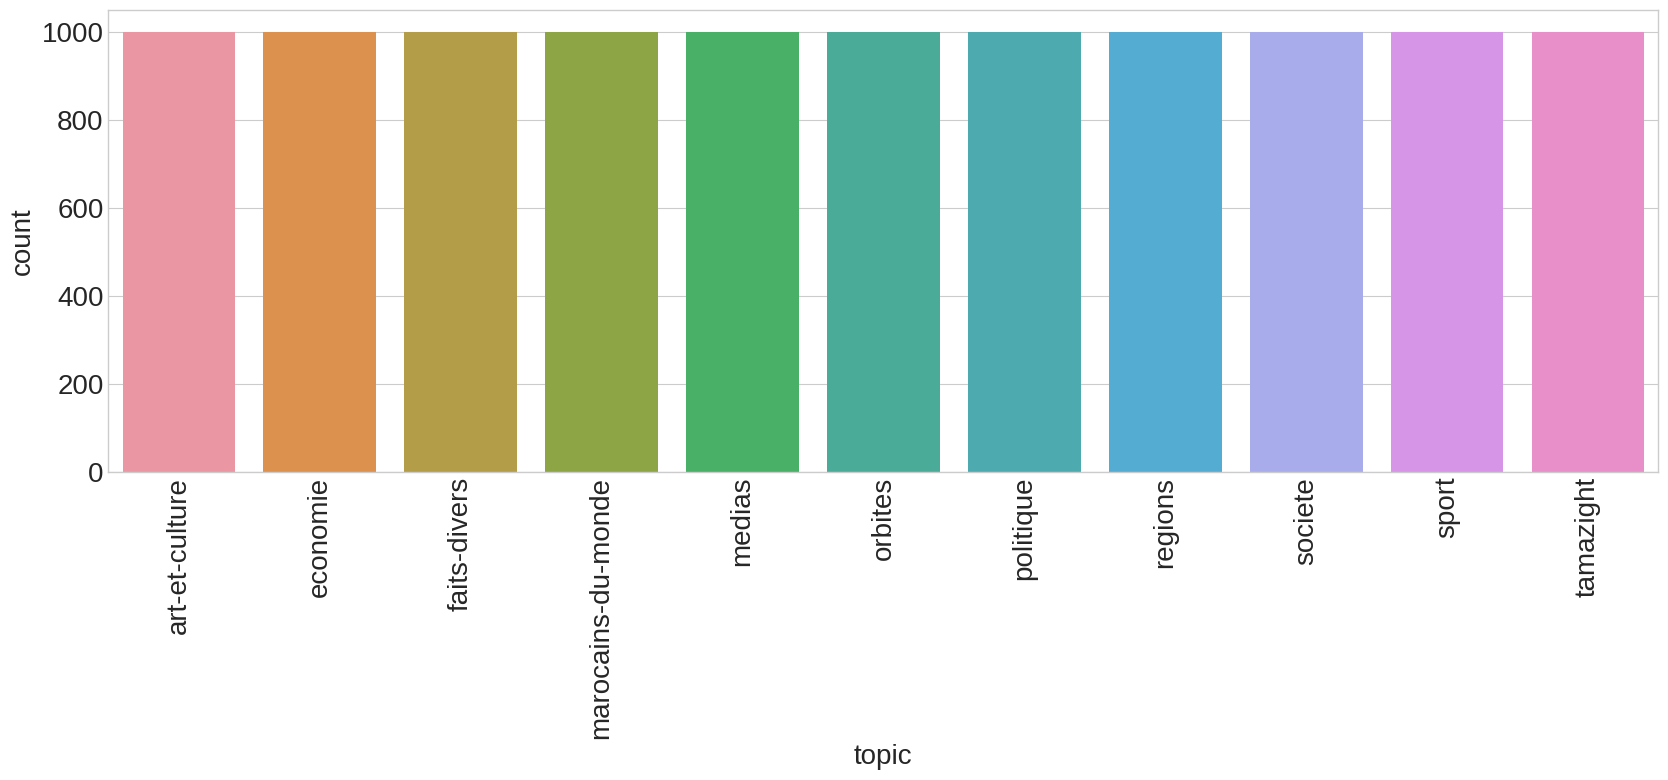

In [206]:
# Assuming big_df is your DataFrame

fig, ax = plt.subplots(figsize=(20, 6))
plt.rcParams.update({'font.size': 20})
data = big_df['topic'].value_counts()

countplot = sns.countplot(x='topic', data=big_df)

# Rotate the x-axis labels by 90 degrees
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

plt.show()

In [208]:
# Required libraries
import nltk
nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words("arabic"))
#from nltk.corpus import stopwords


# Text length analysis
def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))


big_df['word_count'] = big_df['story'].apply(lambda x: len(str(x).split(" ")))
big_df['char_count'] = big_df['story'].str.len() ## this also includes spaces
big_df['avg_char_per_word'] = big_df['story'].apply(lambda x: avg_word(x))
#stop = stopwords.words('arabic')
big_df['stopwords'] = big_df['story'].apply(lambda x: len([x for x in x.split() if x in stop]))
big_df = big_df.sort_values(by='word_count',ascending=[0])
big_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,id,title,date,author,story,topic,word_count,char_count,avg_char_per_word,stopwords
123,123,7f2dd9ac054f11eb9900646e69d991ea,"""هوت ماروك"" لياسين عدنان .. فيضان سردي و""صناعة...",الأحد 23 غشت 2020 - 02:35,محمود الغيطاني*,فيضان سردي هو التوصيف الذي يمكن اطلاقه على روا...,art-et-culture,5916,32432,4.482252,1563
10017,17,b220b7a2055311eb8a0f646e69d991ea,"عصيد: مشكلة حميش مع الأمازيغية تنغمس في ""الموا...",الثلاثاء 21 يوليوز 2020 - 08:24,أحمد عصيد,ثالوث الغلو القومي سعدي العرباوي وخشيمفي الوقت...,tamazight,5694,32634,4.731472,1226
5284,284,f43a91f0055911eb9163646e69d991ea,عصيد يرصد ظاهرة تخريب الآثار وإحراق المكتبات ف...,الأحد 05 يوليوز 2020 - 06:00,أحمد عصيد,ظلت ظاهرة تخريب الماثر التاريخية واحراق الكتب ...,orbites,5651,32087,4.678287,1170
5038,38,aea50b9e055811eb861f646e69d991ea,هل يتجه النظام العالمي إلى بلورة قطبية جديدة ف...,الثلاثاء 22 شتنبر 2020 - 03:00,هسبريس من الرباط,يقارب المهدي طالب الباحث في العلاقات الدولية و...,orbites,4078,24410,4.986023,812
5401,401,6a34e592055a11eb8fa4646e69d991ea,عصيد يستعرض ظاهرة نبش وتخريب القبور في التاريخ...,الأحد 07 يونيو 2020 - 05:00,هسبريس من الرباط,قال الباحث المغربي احمد عصيد ان الاسلام لم يدع...,orbites,4017,22954,4.714464,766


In [209]:
# Overall averages of each numeric column
dataset_stat = big_df.mean(axis=0)
dataset_stat

<ipython-input-209-2924bf11fd34>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_stat = big_df.mean(axis=0)


Unnamed: 0            499.500000
word_count            365.651455
char_count           2221.094545
avg_char_per_word       5.126668
stopwords              64.858364
dtype: float64